In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Clase para cargar y preparar los datos
class LoadData:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        data = pd.read_csv(self.file_path)
        return data

    def prepare_data(self, data):
        # Convertir la columna "Ronda" en variables dummy
        data = pd.get_dummies(data, columns=['Ronda'], drop_first=True)
        
        # Eliminar columnas irrelevantes
        data = data.drop(['idPartido', 'Temporada', 'Evento'], axis=1)

        # Separar características y etiquetas
        X = data.drop(['VictoriaLocal', 'Empate', 'VictoriaVisitante', 'GolesLocal', 'GolesVisitante'], axis=1)
        y = data[['GolesLocal', 'GolesVisitante']]  # Seleccionar goles locales y visitantes como etiquetas

        # Escalar características
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Dividir los datos en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
        
        # Convertir los datos a tensores
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test.values, dtype=tf.float32)
        
        return X_train, X_test, y_train, y_test, scaler, X, y

# Cargar los datos
data_loader = LoadData('../dataframe/champions.csv')
data = data_loader.load_data()
X_train, X_test, y_train, y_test, scaler, X, y = data_loader.prepare_data(data)


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


# Clase para entrenar y evaluar el modelo de predicción de goles locales y visitantes
class GoalsPredictionModel:
    def __init__(self, configurations):
        self.configurations = configurations
        self.best_model = None
        self.best_config = None
        self.best_mae = float('inf')

    def train_model(self, X_train, y_train, X_test, y_test):
        tf.random.set_seed(0)
        for config in self.configurations:
            input_layer = Input(shape=(X_train.shape[1],))
            dense_layer1 = Dense(config['units'], activation='relu')(input_layer)
            dropout_layer1 = Dropout(config['dropout'])(dense_layer1)
            dense_layer2 = Dense(config['units'], activation='relu')(dropout_layer1)
            dropout_layer2 = Dropout(config['dropout'])(dense_layer2)

            # Salida para la predicción de goles locales
            local_goals_output = Dense(1, name='local_goals_output')(dropout_layer2)
            # Salida para la predicción de goles visitantes
            visitor_goals_output = Dense(1, name='visitor_goals_output')(dropout_layer2)
            
            model = Model(inputs=input_layer, outputs=[local_goals_output, visitor_goals_output])

            optimizer = Adam(learning_rate=config['learning_rate'])
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mae'])
            
            history = model.fit(X_train, [y_train[:, 0], y_train[:, 1]], epochs=config['epochs'], batch_size=config['batch_size'], validation_split=0.1)
            
            self.history = history
            _, local_mae, visitor_mae = model.evaluate(X_test, [y_test[:, 0], y_test[:, 1]])
            total_mae = (local_mae + visitor_mae) / 2
            
            if total_mae < self.best_mae:
                self.best_mae = total_mae
                self.best_model = model
                self.best_config = config
            
        return history
    
    def get_best_model(self):
        return self.best_model
    
    def get_best_config(self):
        return self.best_config

# Definir diferentes configuraciones de red y hiperparámetros

configurations = [
    {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.2},
    {'units': 128, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 15, 'dropout': 0.1},
    {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0001, 'batch_size': 16, 'epochs': 10, 'dropout': 0.3},
    {'units': 128, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'dropout': 0.2},
    {'units': 256, 'filters': 128, 'kernel_size': 3, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 10, 'dropout': 0.1},
    {'units': 64, 'filters': 32, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10, 'dropout': 0.1},
    {'units': 128, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20, 'dropout': 0.2},
    {'units': 256, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 15, 'dropout': 0.2},
    {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 20, 'dropout': 0.3},
    {'units': 128, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.2},
    {'units': 256, 'filters': 128, 'kernel_size': 3, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 15, 'dropout': 0.1},
    {'units': 64, 'filters': 32, 'kernel_size': 3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 10, 'dropout': 0.1},
    {'units': 128, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10, 'dropout': 0.1}
]

goals_model_trainer = GoalsPredictionModel(configurations)
goals_model_trainer.train_model(X_train, y_train, X_test, y_test)

goals_model = goals_model_trainer.get_best_model()
best_config = goals_model_trainer.get_best_config()
print("Mejor configuración:", best_config)
    


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - local_goals_output_mae: 1.2357 - loss: 5.7154 - visitor_goals_output_mae: 1.3462 - val_local_goals_output_mae: 1.0902 - val_loss: 3.2824 - val_visitor_goals_output_mae: 0.8089
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - local_goals_output_mae: 1.1041 - loss: 3.5697 - visitor_goals_output_mae: 0.9695 - val_local_goals_output_mae: 1.0536 - val_loss: 3.0898 - val_visitor_goals_output_mae: 0.7858
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - local_goals_output_mae: 1.0895 - loss: 3.3728 - visitor_goals_output_mae: 0.9288 - val_local_goals_output_mae: 1.0428 - val_loss: 3.0442 - val_visitor_goals_output_mae: 0.7773
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - local_goals_output_mae: 1.0460 - loss: 3.1744 - visitor_goals_output_mae: 0.9252 - val_local_goals_output_mae: 1.0329 - val_loss: 3.0188 - val_visitor_goals_output_mae: 0.7890
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - local_goals_output_mae: 1.04

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE para la predicción de goles del local: 0.985853
MAE para la predicción de goles del visitante: 0.8549014


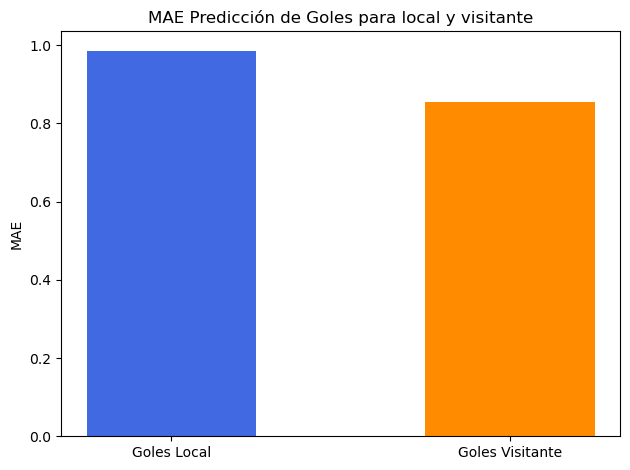

In [3]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

class ModelEvaluation:
    def __init__(self, model):
        self.model = model
    
    def evaluate_model(self, X_test, y_test):
        # Evaluar el modelo
        local_goals_pred, visitor_goals_pred = self.model.predict(X_test)

        # Calcular y mostrar el MAE para cada tipo de predicción
        local_mae = mean_absolute_error(y_test[:, 0], local_goals_pred)
        visitor_mae = mean_absolute_error(y_test[:, 1], visitor_goals_pred)
        
        print("MAE para la predicción de goles del local:", local_mae)
        print("MAE para la predicción de goles del visitante:", visitor_mae)

        # Graficar los resultados
        labels = ['Goles Local', 'Goles Visitante']
        mae_values = [local_mae, visitor_mae]

        plt.bar(labels, mae_values, width=0.5,  color=['royalblue', 'darkorange'])
        plt.ylabel('MAE')
        plt.title('MAE Predicción de Goles para local y visitante')
        plt.tight_layout()
        plt.savefig('../resultados/mae_redes_goles.png')
        plt.show()
    

model_evaluator = ModelEvaluation(goals_model)
model_evaluator.evaluate_model(X_test, y_test)

Un MAE de alrededor de 1 indica que, en promedio, las predicciones del modelo pueden estar desviadas hasta 1 gol por encima o por debajo del valor real. Esto sugiere que las predicciones del modelo podrían variar en un rango de aproximadamente ±1 gol de los valores reales. Lo mismo con los goles del viistante.

In [4]:
# Guardar el modelo
tf.keras.models.save_model(goals_model, '../modelos/modelo_dnn_goals.keras')
model = tf.keras.models.load_model('../modelos/modelo_dnn_goals.keras')

In [8]:
#!jupyter nbconvert --to script dnn_goles.ipynb